In [1]:
import anndata as ad
import os
import re
import numpy as np
import squidpy as sq
import scanpy as sc
import harmonypy as hm
import umap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress

In [2]:
# Load single-nucleus nuclear protein intensity from one brain section
folder = "cell_measurement/ave_int/"

# collect all h5ad file paths
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".h5ad")]

# read all into a list
adatas = [sc.read_h5ad(f) for f in files]

# concatenate into one AnnData
adata = ad.concat(adatas, join="outer", label="batch", keys=[os.path.basename(f) for f in files])

print(adata)

AnnData object with n_obs × n_vars = 178927 × 18
    obs: 'batch'


In [3]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
# Load nuclear protein intensity matrix from another brain section, preprocessed the same way

adata_1st_brain = ad.read_h5ad('./first_brain_measurement/ave_intensity_matrix.h5ad')

In [5]:
# make a matrix with the 16 common nuclear markers in both brains

common_vars = adata_1st_brain.var_names.intersection(adata.var_names)
adata_1 = adata_1st_brain[:, common_vars].copy()
adata_2 = adata[:, common_vars].copy()

In [6]:
adata_both = ad.concat([adata_1, adata_2],
                      join="outer",     # keep all features
                      label="dataset",  # new column in .obs
                      keys=["1st_brain", "2nd_brain"])  

C:\Users\liany\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
common_genes = adata_1.var_names.intersection(adata_2.var_names)
len(common_genes)

15

In [8]:
adata_raw1 = ad.AnnData(X=adata_1.layers["counts"].copy(),
                       obs=adata_1.obs.copy(),
                       var=adata_1.var.copy())
adata_raw2 = ad.AnnData(X=adata_2.layers["counts"].copy(),
                       obs=adata_2.obs.copy(),
                       var=adata_2.var.copy())

Fit (log10-scale): y ≈ 10^(1.61·log10(x) + -1.19)
R (log-space): 0.9337, p-value = 3.656e-07


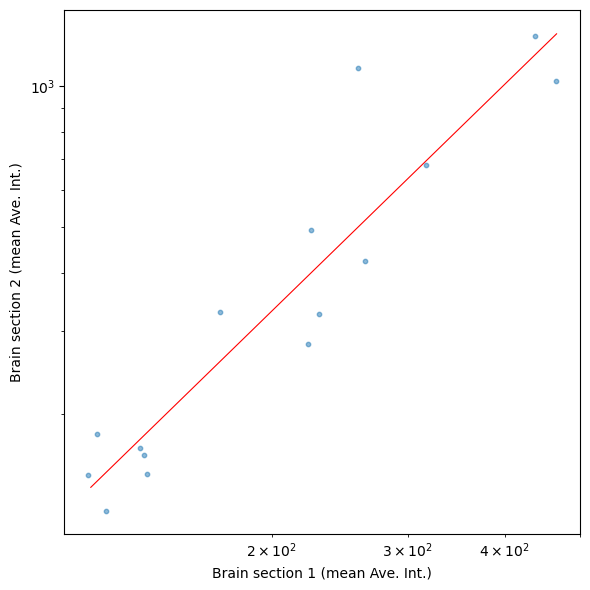

In [23]:

# ---- Extract matrices ----
X1 = adata_raw1[:, common_genes].X   # brain section 1
X2 = adata_raw2[:, common_genes].X   # brain section 2

# Convert sparse -> dense
if not isinstance(X1, np.ndarray):
    X1 = X1.toarray()
if not isinstance(X2, np.ndarray):
    X2 = X2.toarray()

# ---- Mean raw counts per gene ----
gexp2 = np.mean(X1, axis=0)   # Brain section 1
gexp1 = np.mean(X2, axis=0)   # Brain section 2


# ---- Linear regression in log10 space ----
log_gexp1 = np.log10(gexp1 + 1)
log_gexp2 = np.log10(gexp2 + 1)

slope, intercept, r_value, p_value, std_err = linregress(log_gexp1, log_gexp2)

# Regression line (sorted by x)
order = np.argsort(log_gexp1)
log_x_sorted = log_gexp1[order]
log_y_fit_sorted = slope * log_x_sorted + intercept

# ---- Plot ----
plt.figure(figsize=(6, 6))

plt.scatter(gexp1, gexp2, alpha=0.5, s=10)
plt.plot(10**log_x_sorted, 10**log_y_fit_sorted, color="red", linewidth=0.8)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Brain section 1 (mean Ave. Int.)")
plt.ylabel("Brain section 2 (mean Ave. Int.)")

print(f"Fit (log10-scale): y ≈ 10^({slope:.2f}·log10(x) + {intercept:.2f})")
print(f"R (log-space): {r_value:.4f}, p-value = {p_value:.3e}")

plt.tight_layout()
# plt.savefig("protein_correlation_normalized_log.eps", format='eps')
plt.show()
plt.close()